# 꽃 이미지 분류기

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from PIL import Image
import gc

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
from torchsummary import summary

from sklearn.metrics import accuracy_score

In [4]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [5]:
import pathlib

# 데이터 경로
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('./flower_photos', origin=dataset_url, untar=True) # untar=True -> 압축 풀기

# pathlib모듈 -> 파일의 경로를 객체로써 조작하거나 처리할 수 있다.
data_dir = pathlib.Path(data_dir)
print(data_dir)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


In [6]:
print(data_dir) # 데이터가 저장된 경로 확인

/Users/kimhongseok/.keras/datasets/flower_photos


### data 확인

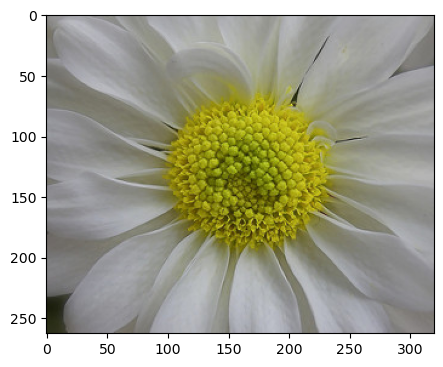

In [5]:
flower_img = Image.open('./flower_photos/daisy/100080576_f52e8ee070_n.jpg')

plt.figure(figsize=(5, 5))
plt.imshow(flower_img)
plt.show()

# CustomDataset

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    # 데이터의 형태 정의 및 하나의 변수에 저장
    def __init__(self, root_dir, transform, classes):
        super().__init__()
        self.root_dir = root_dir # 이미지 데이터 기본 경로
        self.transform = transform # tensor형태로 변환하기 위한 함수
        self.classes = classes
        self.images = list()
        
        for label, cls in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, cls)
            img_list = os.listdir(class_dir)
            for img in img_list:
                self.images.append((os.path.join(class_dir, img), label))

    # 데이터의 개수 반환
    def __len__(self):
        return len(self.images)
    
    # 특정 데이터 반환
    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img_tmp = Image.open(img_path).convert('RGB')
        img = self.transform(img_tmp)
        return img, label

In [7]:
data_root_dir = './flower_photos'

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

classes = os.listdir(data_root_dir)[:-1]

all_dataset = CustomDataset(data_root_dir, transform, classes)

In [8]:
print(classes)

['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']


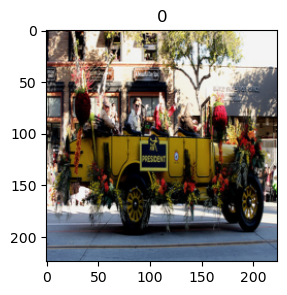

In [9]:
plt.figure(figsize=(3, 3))
plt.imshow(all_dataset[0][0].permute((1, 2, 0)))
plt.title(all_dataset[0][1])
plt.show()

In [10]:
# train, valid, test 구분
total_num = len(all_dataset)
print(total_num)
train_num, valid_num, test_num = int(total_num*0.5), int(total_num*0.2), int(total_num*0.3)

print(train_num, valid_num, test_num)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(all_dataset, [train_num, valid_num, test_num])

3670
1835 734 1101


### DataLoader

In [11]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

In [12]:
print(len(train_dataloader))

for images, labels in train_dataloader:
    print(len(images))
    print(images.shape)
    print(labels)
    break

58
32
torch.Size([32, 3, 224, 224])
tensor([1, 3, 0, 0, 0, 0, 1, 4, 3, 3, 1, 4, 0, 3, 2, 0, 4, 4, 4, 0, 2, 3, 2, 4,
        0, 4, 3, 1, 4, 2, 0, 3])


# Model 생성

In [19]:
class CNN_v1(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=224*224*32, out_features=1024),
            torch.nn.Linear(in_features=1024, out_features=5),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        output = self.layer(x)
        return output

In [20]:
model_test = CNN_v1()
summary(model_test, input_size=(3, 224, 224))

del model_test
gc.collect()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 224, 224]               0
            Conv2d-5         [-1, 32, 224, 224]           4,640
       BatchNorm2d-6         [-1, 32, 224, 224]              64
              ReLU-7         [-1, 32, 224, 224]               0
         MaxPool2d-8         [-1, 32, 224, 224]               0
           Flatten-9              [-1, 1605632]               0
           Linear-10                 [-1, 1024]   1,644,168,192
           Linear-11                    [-1, 5]           5,125
       LogSoftmax-12                    [-1, 5]               0
Total params: 1,644,178,501
Trainable params: 1,644,178,501
Non-trainable params: 0
-------------------

912

# train, eval 함수

In [21]:
def training(model, train_dataloader, train_dataset, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    tbar = tqdm(valid_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        valid_accuracy += (labels == outputs).sum().item()

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(epoch + 1)
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

In [22]:
model1 = CNN_v1()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

model = training_loop(model1, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 5)

1


  0%|          | 0/58 [00:00<?, ?it/s]

[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 